## **VGG-16 Model**

### **Installation**

In [1]:
!pip -q install torch torchvision 

In [2]:
%pip -q install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Install extra dependencies for metrics/plots
%pip -q install scikit-learn

Note: you may need to restart the kernel to use updated packages.


### **Configurations & Declarations**

#### Import

In [2]:
import os, io, math, random, glob
from pathlib import Path

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import cv2

In [3]:
# Metrics for evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

#### Constant Declaration

In [4]:
import torch
import os

DATASET_ROOT="../Dataset"

TRAIN_DIR=f"{DATASET_ROOT}/Train"
VAL_DIR=f"{DATASET_ROOT}/Validation"
TEST_DIR=f"{DATASET_ROOT}/Test"
OUTPUT_DIR = "./output"

# Fixed: Use the correct path where the checkpoint actually exists
MODEL_CHECKPOINT_PATH="../VGG16-checkpoint/deepfake_cnn.pt"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 8
BATCH_SIZE = 48
IMG_SIZE = 244
NUM_WORKERS = 4
WARMUP_EPOCHS = 4
LR_HEAD        = 1e-3
LR_BACKBONE    = 3e-4
WEIGHT_DECAY   = 1e-4
MIXUP_ALPHA    = 0.4
MIXUP_PROB     = 0.8

LABELS = ["real", "fake"]
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
# Device and environment check
import platform
import numpy as np

print("== Environment / Device Info ==")
print(f"OS          : {platform.system()} {platform.release()} ({platform.version()})")
print(f"Python      : {platform.python_version()}")
print(f"PyTorch     : {torch.__version__}")
try:
    import cv2 as _cv2
    print(f"OpenCV      : {_cv2.__version__}")
except Exception:
    print("OpenCV      : not installed")
print(f"NumPy       : {np.__version__}")

if torch.cuda.is_available():
    n = torch.cuda.device_count()
    print(f"CUDA        : available (devices={n})")
    print(f"CUDA runtime: {torch.version.cuda}")
    try:
        print(f"cuDNN       : {torch.backends.cudnn.version()}")
    except Exception:
        print("cuDNN       : unknown")
    for i in range(n):
        props = torch.cuda.get_device_properties(i)
        total_gb = props.total_memory / (1024**3)
        cc = f"{props.major}.{props.minor}"
        print(f"  GPU[{i}]     : {props.name} | VRAM: {total_gb:.1f} GB | CC: {cc}")
else:
    print("CUDA        : not available -> using CPU")
print(f"Selected    : {DEVICE}")

== Environment / Device Info ==
OS          : Windows 11 (10.0.26100)
Python      : 3.13.5
PyTorch     : 2.7.1+cu118
OpenCV      : 4.12.0
NumPy       : 2.1.3
CUDA        : available (devices=1)
CUDA runtime: 11.8
cuDNN       : 90100
  GPU[0]     : NVIDIA GeForce RTX 4050 Laptop GPU | VRAM: 6.0 GB | CC: 8.9
Selected    : cuda


#### Model Setup

In [6]:
import os, io, math, random, glob
from pathlib import Path

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import cv2

# Spatial Rich Model Layer
class SRMConv(nn.Module):
    """
    Fixed high-pass SRM filters (3 kernels) applied depthwise to RGB -> 9ch -> 1x1 fuse -> 3ch.
    """
    def __init__(self):
        super().__init__()
        k = torch.tensor(
            [
                [[0, -1, 0], [-1, 4, -1], [0, -1, 0]],
                [[-1, 2, -1], [2, -4, 2], [-1, 2, -1]],
                [[0, 0, 0], [0, 1, -1], [0, -1, 0]],
            ],
            dtype=torch.float32,
        ).unsqueeze(1)  # (3,1,3,3)

        # Depthwise conv: 3 input chans, 9 output chans, groups=3 -> 3 outputs per input group
        self.depthwise = nn.Conv2d(
            in_channels=3, out_channels=9, kernel_size=3, padding=1, bias=False, groups=3
        )
        with torch.no_grad():
            # Repeat the 3 kernels for each of the 3 channel groups -> (9,1,3,3)
            kernels = k.repeat(3, 1, 1, 1)
            self.depthwise.weight.copy_(kernels)
        for p in self.depthwise.parameters():
            p.requires_grad = False  # fixed SRM filters

        self.fuse = nn.Conv2d(9, 3, kernel_size=1, bias=False)  # learnable 1x1 to adapt SRM outputs

    def forward(self, x):
        x = self.depthwise(x)
        x = self.fuse(x)
        return x

# Forensic Model with VGG16 Backbone
class ForensicVGG16(nn.Module):
    """
    SRM -> VGG16 conv features -> GAP head (BN+Dropout+Linear) -> 1 logit (real/fake).
    """
    def __init__(self, pretrained=True, dropout=0.4):
        super().__init__()
        self.srm = SRMConv()
        self.backbone = vgg16(weights=VGG16_Weights.IMAGENET1K_FEATURES if pretrained else None).features
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        x = self.srm(x)
        x = self.backbone(x)
        x = self.pool(x)
        x = self.head(x).squeeze(1)  # (B,)
        return x



#### Data Preprocessing Setup

In [7]:
import os, io, math, random, glob
from pathlib import Path

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import cv2

# Data Augmentations Layer - increase data diversity
class RandomJPEG:
    def __init__(self, qmin=40, qmax=100, p=0.7):
        self.qmin, self.qmax, self.p = qmin, qmax, p
    def __call__(self, img: Image.Image):
        if random.random() > self.p:
            return img
        buf = io.BytesIO()
        img.save(buf, format="JPEG", quality=random.randint(self.qmin, self.qmax))
        buf.seek(0)
        return Image.open(buf).convert("RGB")

# Gaussian Noise Layer - regulate data to prevent overfitting
class AddGaussianNoise(torch.nn.Module): 
    def __init__(self, std=0.01, p=0.5): 
        super().__init__()
        self.std, self.p = std, p
    def forward(self, x):
        if random.random() > self.p:
            return x
        return x + torch.randn_like(x) * self.std

# Dataset Class - Format the Image to fit the model
class ImageFolderBinary(Dataset):
    """
    root/
      real/*.jpg|png
      fake/*.jpg|png
    Returns (tensor, float_label)
    """
    def __init__(self, root, transform=None):
        self.root = Path(root)
        self.samples = []
        for cls, label in [("real", 0.0), ("fake", 1.0)]:
            for p in sorted((self.root / cls).glob("*")):
                if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}:
                    self.samples.append((str(p), label))
        assert len(self.samples), f"No images found under {root}"
        self.transform = transform or get_transforms(train=True)

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float32)
    
# Data Augmentation Transforms
def get_transforms(train=True):
    return transforms.Compose([
        transforms.Resize(int(IMG_SIZE * 1.1)),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0), ratio=(0.95, 1.05)) if train else transforms.CenterCrop(IMG_SIZE),
        RandomJPEG(40, 100, p=0.7 if train else 0.0),
        transforms.RandomHorizontalFlip(p=0.5 if train else 0.0),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02) if train else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        AddGaussianNoise(std=0.01, p=0.5 if train else 0.0),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)) if train else transforms.Lambda(lambda x: x),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])

# Mixup Collate Function - reduce overconfidence on ambiguous cases 
def mixup_collate(batch, alpha=MIXUP_ALPHA, p=MIXUP_PROB):
    imgs = torch.stack([b[0] for b in batch], dim=0) 
    labels = torch.stack([b[1] for b in batch], dim=0)  # (B,) 
    if random.random() > p or len(batch) < 2: 
        return imgs, labels
    lam = torch.distributions.Beta(alpha, alpha).sample().item()
    perm = torch.randperm(imgs.size(0))
    mixed_imgs = lam * imgs + (1 - lam) * imgs[perm]
    mixed_labels = lam * labels + (1 - lam) * labels[perm]
    return mixed_imgs, mixed_labels


#### Utilities Declaration

In [8]:
def get_last_conv(module: nn.Module):
    last = None
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    return last

def de_normalize(img_tensor):
    mean = torch.tensor([0.485,0.456,0.406], device=img_tensor.device).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225], device=img_tensor.device).view(3,1,1)
    return (img_tensor * std + mean).clamp(0,1)

def overlay_cam(img_tensor, cam_tensor):
    """Return RGB uint8 overlay for visualization."""
    img = (de_normalize(img_tensor).permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)  # HWC
    cam = (cam_tensor.cpu().numpy() * 255).astype(np.uint8)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (0.45 * heatmap + 0.55 * img).astype(np.uint8)
    return overlay

def set_trainable(mod, flag: bool):
    for p in mod.parameters():
        p.requires_grad = flag

def accuracy_from_logits(logits, labels):
    preds = (torch.sigmoid(logits) >= 0.5).float()
    return (preds == labels).float().mean().item()


# Evaluation helper (prints metrics, shows/saves CM and ROC)
import os
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

os.makedirs(OUTPUT_DIR, exist_ok=True)

@torch.no_grad()
def evaluate_and_report(dataloader, model, device, save_prefix=f"{OUTPUT_DIR}/eval"):
    model.eval()
    all_targets, all_probs = [], []
    with tqdm(dataloader, desc="Reporting", leave=False, dynamic_ncols=True) as pbar:
        for imgs, labels in pbar:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_targets.append(labels.cpu().numpy())

    y_true = np.concatenate(all_targets).ravel().astype(int)
    y_probs = np.concatenate(all_probs).ravel()
    y_pred = (y_probs >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_probs)
    except Exception:
        auc = float('nan')

    print("=== Evaluation Report ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")
    report_txt = classification_report(y_true, y_pred, target_names=LABELS, zero_division=0)
    print("\nClassification Report:\n", report_txt)

    with open(f"{save_prefix}_report.txt", "w", encoding="utf-8") as f:
        f.write("Evaluation\n")
        f.write(f"Accuracy : {acc:.4f}\n")
        f.write(f"Precision: {prec:.4f}\n")
        f.write(f"Recall   : {rec:.4f}\n")
        f.write(f"F1-score : {f1:.4f}\n")
        f.write(f"AUC      : {auc:.4f}\n\n")
        f.write(report_txt)

    # Confusion matrix
    fig, ax = plt.subplots(figsize=(5,5))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=LABELS, cmap=plt.cm.Blues, ax=ax)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    cm_path = f"{save_prefix}_confusion_matrix.png"
    fig.savefig(cm_path, dpi=150)
    print(f"Confusion matrix saved to {cm_path}")
    plt.show()

    # ROC curve
    try:
        fig2, ax2 = plt.subplots(figsize=(6,6))
        RocCurveDisplay.from_predictions(y_true, y_probs, name="model", ax=ax2)
        plt.title("ROC Curve")
        plt.tight_layout()
        roc_path = f"{save_prefix}_roc.png"
        fig2.savefig(roc_path, dpi=150)
        print(f"ROC plot saved to {roc_path}")
        plt.show()
    except Exception as e:
        print("Could not plot ROC:", e)

### **Implementation & Build**

#### Dataset Review

TRAIN_DIR: ../Dataset/Train
Number of image files found: 70001


,filename
0,real_0.jpg
1,real_1.jpg
2,real_10.jpg
3,real_100.jpg
4,real_1000.jpg
5,real_10000.jpg
6,real_10001.jpg
7,real_10002.jpg
8,real_10003.jpg
9,real_10004.jpg


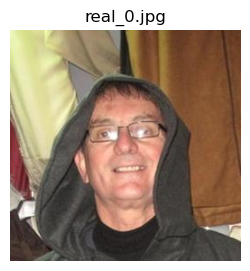

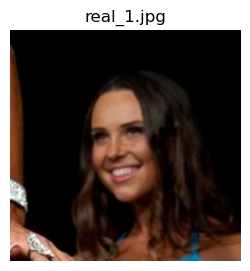

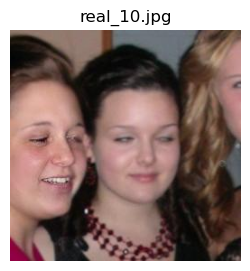

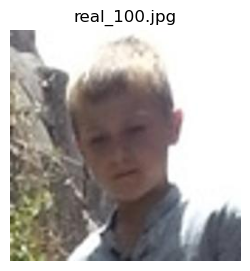

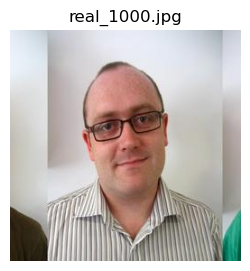

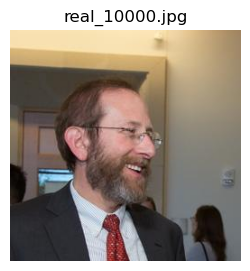

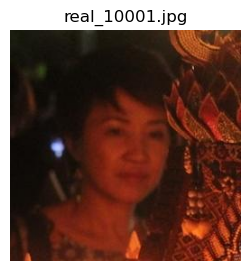

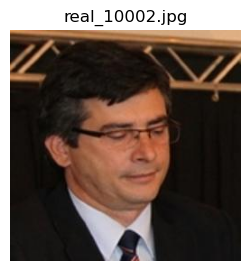

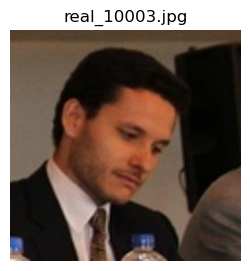

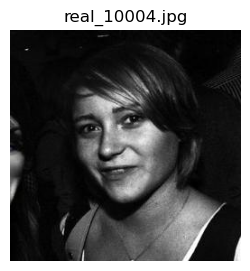

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path



# Step 1: Collect image files
image_dir = Path(TRAIN_DIR + "/Real")
image_files = [f for f in image_dir.iterdir() if f.suffix.lower() in [".jpg", ".jpeg", ".png"]]

print("TRAIN_DIR:", TRAIN_DIR)
print("Number of image files found:", len(image_files))
# Step 2: Create DataFrame for first 10 filenames
df = pd.DataFrame({"filename": [f.name for f in image_files[:10]]})
display(df)

# Step 3: Preview first 10 images
for i, file_path in enumerate(image_files[:10]):
    img = cv2.imread(str(file_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert BGR to RGB
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(file_path.name)
    plt.axis("off")
    plt.show()


#### DataLoaders

In [12]:
train_ds = ImageFolderBinary(TRAIN_DIR, transform=get_transforms(train=True))
val_ds   = ImageFolderBinary(VAL_DIR,   transform=get_transforms(train=False))

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=True, collate_fn=mixup_collate)
val_dl = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True,
                      collate_fn=lambda b: (torch.stack([x for x,_ in b]), torch.stack([y for _,y in b])) )

#### Models

##### Model Declaration 

In [13]:
model = ForensicVGG16(pretrained=True, dropout=0.4).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0], device=DEVICE))

In [14]:
# Batch-size and DataLoader tuning (Windows/GPU)
import platform, math, gc
print("== Dataloader tuning ==")

# Prefer conservative workers on Windows notebooks to avoid DataLoader hangs
recommended_workers = 0 if platform.system() == "Windows" else min(NUM_WORKERS, 4)

def _can_fit_batch(bs: int) -> bool:
    if DEVICE != "cuda":
        return True
    try:
        torch.cuda.empty_cache()
        # Use train mode to reflect typical memory pattern (activations), but don't step optimizer
        model.train()
        dummy = torch.randn(bs, 3, IMG_SIZE, IMG_SIZE, device=DEVICE)
        target = torch.rand(bs, device=DEVICE)
        with torch.amp.autocast('cuda', enabled=(DEVICE == "cuda")):
            logits = model(dummy)
            loss = criterion(logits, target)
        # Backward once to include grad memory, then clear
        loss.backward()
        model.zero_grad(set_to_none=True)
        del dummy, target, logits, loss
        torch.cuda.synchronize()
        torch.cuda.empty_cache()
        return True
    except RuntimeError as e:
        msg = str(e).lower()
        if "out of memory" in msg or "cuda error" in msg:
            torch.cuda.empty_cache()
            return False
        raise

# Heuristic search: start from current BATCH_SIZE (capped) and reduce on OOM
if DEVICE == "cuda":
    probe_start = max(8, min(BATCH_SIZE, 64))
    bs_probe = probe_start
    while bs_probe >= 1 and not _can_fit_batch(bs_probe):
        bs_probe //= 2
    recommended_bs = max(1, bs_probe)
else:
    # CPU default
    recommended_bs = min(BATCH_SIZE, 8)

old_bs, old_workers = BATCH_SIZE, NUM_WORKERS
BATCH_SIZE = recommended_bs
NUM_WORKERS = recommended_workers

# Enable cuDNN autotune for speed if on CUDA
if DEVICE == "cuda":
    torch.backends.cudnn.benchmark = True

# Rebuild DataLoaders with tuned settings
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE == "cuda"),
    collate_fn=mixup_collate,
)
val_dl = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE == "cuda"),
    collate_fn=lambda b: (torch.stack([x for x, _ in b]), torch.stack([y for _, y in b])),
)

steps_train = math.ceil(len(train_ds) / BATCH_SIZE)
steps_val = math.ceil(len(val_ds) / BATCH_SIZE)
print(f"Workers: {old_workers} -> {NUM_WORKERS}")
print(f"Batch size: {old_bs} -> {BATCH_SIZE}")
print(f"Train steps/epoch: {steps_train} | Val steps/epoch: {steps_val}")

== Dataloader tuning ==
Workers: 4 -> 0
Batch size: 48 -> 48
Train steps/epoch: 2917 | Val steps/epoch: 822


##### Stage 0: Freeze Backbone and train head only

== Warmup (head only) ==


Warmup 1/4:   0%|          | 0/2917 [00:00<?, ?it/s]

Validate (warmup 1):   0%|          | 0/822 [00:00<?, ?it/s]

Warmup 1/4  TRAIN: loss=0.7803 acc=0.6903
Warmup 1/4  VAL  : loss=0.7010 acc=0.6657 prec=0.6029 rec=0.9635 f1=0.7417 auc=0.8681
  ✓ Saved best @ acc=0.6657 -> ./deepfake_cnn.pt


Warmup 2/4:   0%|          | 0/2917 [00:00<?, ?it/s]

Validate (warmup 2):   0%|          | 0/822 [00:00<?, ?it/s]

Warmup 2/4  TRAIN: loss=0.7523 acc=0.7095
Warmup 2/4  VAL  : loss=0.6802 acc=0.6760 prec=0.6103 rec=0.9671 f1=0.7483 auc=0.8754
  ✓ Saved best @ acc=0.6760 -> ./deepfake_cnn.pt


Warmup 3/4:   0%|          | 0/2917 [00:00<?, ?it/s]

Validate (warmup 3):   0%|          | 0/822 [00:00<?, ?it/s]

Warmup 3/4  TRAIN: loss=0.7386 acc=0.7214
Warmup 3/4  VAL  : loss=0.6625 acc=0.6790 prec=0.6126 rec=0.9676 f1=0.7502 auc=0.8853
  ✓ Saved best @ acc=0.6790 -> ./deepfake_cnn.pt


Warmup 4/4:   0%|          | 0/2917 [00:00<?, ?it/s]

Validate (warmup 4):   0%|          | 0/822 [00:00<?, ?it/s]

Warmup 4/4  TRAIN: loss=0.7276 acc=0.7275
Warmup 4/4  VAL  : loss=0.6647 acc=0.6870 prec=0.6190 rec=0.9665 f1=0.7547 auc=0.8813
  ✓ Saved best @ acc=0.6870 -> ./deepfake_cnn.pt


Reporting:   0%|          | 0/822 [00:00<?, ?it/s]

=== Evaluation Report ===
Accuracy : 0.6870
Precision: 0.6191
Recall   : 0.9663
F1-score : 0.7547
AUC      : 0.8813

Classification Report:
               precision    recall  f1-score   support

        real       0.92      0.41      0.57     19787
        fake       0.62      0.97      0.75     19641

    accuracy                           0.69     39428
   macro avg       0.77      0.69      0.66     39428
weighted avg       0.77      0.69      0.66     39428

Confusion matrix saved to ./output/eval_warmup_confusion_matrix.png


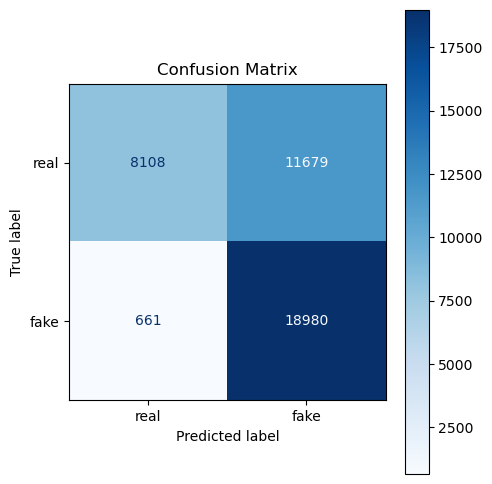

ROC plot saved to ./output/eval_warmup_roc.png


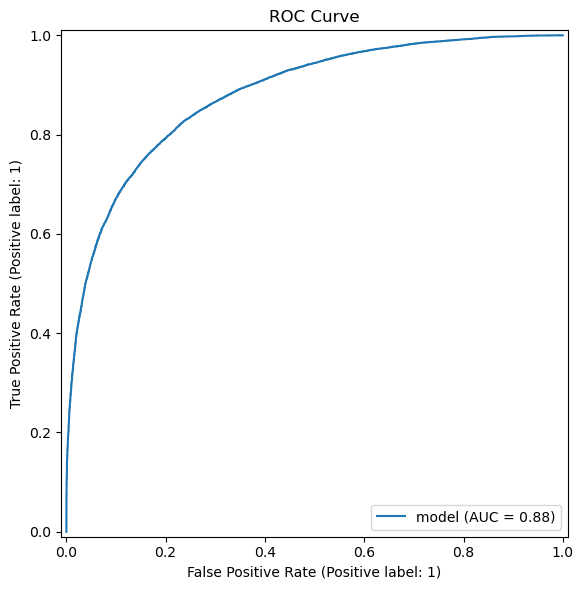

In [16]:
set_trainable(model.backbone, False)
set_trainable(model.head, True)
set_trainable(model.srm.fuse, True)
optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=LR_HEAD, weight_decay=WEIGHT_DECAY)
scaler = torch.amp.GradScaler(enabled=(DEVICE=="cuda"))

best_val_acc, best_state = -1.0, None

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


def run_epoch(dl, train=True, desc=""):
    model.train(mode=train)
    total_loss, total_n = 0.0, 0
    all_targets, all_probs = [], []

    with tqdm(dl, desc=desc, leave=False, dynamic_ncols=True) as pbar:
        for imgs, labels in pbar:
            imgs = imgs.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            if train:
                optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda', enabled=(DEVICE=="cuda")):
                logits = model(imgs)
                loss = criterion(logits, labels)
            if train:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            probs = torch.sigmoid(logits.detach())
            all_probs.append(probs.cpu().numpy())
            all_targets.append(labels.detach().cpu().numpy())
            bs = imgs.size(0)
            total_loss += float(loss) * bs
            total_n    += bs
            # running acc for pbar
            run_acc = accuracy_from_logits(logits.detach(), labels)
            pbar.set_postfix(loss=total_loss/total_n, acc=run_acc)

    # aggregate
    y_true = np.concatenate(all_targets).ravel()
    y_true_bin = (y_true >= 0.5).astype(int)
    y_probs = np.concatenate(all_probs).ravel()
    y_pred = (y_probs >= 0.5).astype(int)

    acc = float(accuracy_score(y_true_bin, y_pred))
    prec = float(precision_score(y_true_bin, y_pred, zero_division=0))
    rec = float(recall_score(y_true_bin, y_pred, zero_division=0))
    f1 = float(f1_score(y_true_bin, y_pred, zero_division=0))
    try:
        auc = float(roc_auc_score(y_true_bin, y_probs))
    except Exception:
        auc = float('nan')
    conf = confusion_matrix(y_true_bin, y_pred)

    return total_loss/total_n, acc, prec, rec, f1, auc, conf

print("== Warmup (head only) ==")
for ep in range(1, WARMUP_EPOCHS+1):
    tr_loss, tr_acc, tr_prec, tr_rec, tr_f1, tr_auc, tr_conf = run_epoch(train_dl, train=True,  desc=f"Warmup {ep}/{WARMUP_EPOCHS}")
    va_loss, va_acc, va_prec, va_rec, va_f1, va_auc, va_conf = run_epoch(val_dl,   train=False, desc=f"Validate (warmup {ep})")
    print(f"Warmup {ep}/{WARMUP_EPOCHS}  TRAIN: loss={tr_loss:.4f} acc={tr_acc:.4f}")
    print(f"Warmup {ep}/{WARMUP_EPOCHS}  VAL  : loss={va_loss:.4f} acc={va_acc:.4f} prec={va_prec:.4f} rec={va_rec:.4f} f1={va_f1:.4f} auc={va_auc:.4f}")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        torch.save(best_state, MODEL_CHECKPOINT_PATH)
        print(f"  ✓ Saved best @ acc={best_val_acc:.4f} -> {MODEL_CHECKPOINT_PATH}")

# Evaluate right after warmup
evaluate_and_report(val_dl, model, DEVICE, save_prefix=f"{OUTPUT_DIR}/eval_warmup")

##### Step 1: Unfreeze top layers of backbone, discriminative LRs + cosine

In [17]:
for m in list(model.backbone.children())[-10:]:
    set_trainable(m, True)

optimizer = AdamW(
    [
        {"params": model.head.parameters(), "lr": LR_HEAD},
        {"params": filter(lambda p: p.requires_grad, model.backbone.parameters()), "lr": LR_BACKBONE},
        {"params": model.srm.fuse.parameters(), "lr": LR_BACKBONE},
    ],
    weight_decay=WEIGHT_DECAY
)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS - WARMUP_EPOCHS)

print("== Fine-tune top blocks ==")
for ep in range(1, EPOCHS - WARMUP_EPOCHS + 1):
    tr_loss, tr_acc, tr_prec, tr_rec, tr_f1, tr_auc, tr_conf = run_epoch(train_dl, train=True,  desc=f"Train {ep}/{EPOCHS-WARMUP_EPOCHS}")
    va_loss, va_acc, va_prec, va_rec, va_f1, va_auc, va_conf = run_epoch(val_dl,   train=False, desc=f"Validate {ep}")
    scheduler.step()

    print(f"Train {ep}/{EPOCHS-WARMUP_EPOCHS}  TRAIN: loss={tr_loss:.4f} acc={tr_acc:.4f}")
    print(f"Train {ep}/{EPOCHS-WARMUP_EPOCHS}  VAL  : loss={va_loss:.4f} acc={va_acc:.4f} prec={va_prec:.4f} rec={va_rec:.4f} f1={va_f1:.4f} auc={va_auc:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        torch.save(best_state, MODEL_CHECKPOINT_PATH)
        print(f"  ✓ Saved best @ acc={best_val_acc:.4f} -> {MODEL_CHECKPOINT_PATH}")

print(f"Best validation accuracy: {best_val_acc:.4f}")
# Load best weights for visualization
if best_state is not None:
    model.load_state_dict(best_state)
else:
    torch.save({k: v.cpu() for k,v in model.state_dict().items()}, MODEL_CHECKPOINT_PATH)

== Fine-tune top blocks ==


Train 1/4:   0%|          | 0/2917 [00:00<?, ?it/s]

Validate 1:   0%|          | 0/822 [00:00<?, ?it/s]

Train 1/4  TRAIN: loss=0.4269 acc=0.9107
Train 1/4  VAL  : loss=0.3114 acc=0.9225 prec=0.8762 rec=0.9834 f1=0.9267 auc=0.9884
  ✓ Saved best @ acc=0.9225 -> ./deepfake_cnn.pt


Train 2/4:   0%|          | 0/2917 [00:00<?, ?it/s]

Validate 2:   0%|          | 0/822 [00:00<?, ?it/s]

Train 2/4  TRAIN: loss=0.3616 acc=0.9315
Train 2/4  VAL  : loss=0.2128 acc=0.9366 prec=0.8932 rec=0.9913 f1=0.9397 auc=0.9931
  ✓ Saved best @ acc=0.9366 -> ./deepfake_cnn.pt


Train 3/4:   0%|          | 0/2917 [00:00<?, ?it/s]

Validate 3:   0%|          | 0/822 [00:00<?, ?it/s]

Train 3/4  TRAIN: loss=0.3484 acc=0.9374
Train 3/4  VAL  : loss=0.2225 acc=0.9610 prec=0.9405 rec=0.9840 f1=0.9618 auc=0.9950
  ✓ Saved best @ acc=0.9610 -> ./deepfake_cnn.pt


Train 4/4:   0%|          | 0/2917 [00:00<?, ?it/s]

Validate 4:   0%|          | 0/822 [00:00<?, ?it/s]

Train 4/4  TRAIN: loss=0.3252 acc=0.9438
Train 4/4  VAL  : loss=0.2598 acc=0.9333 prec=0.8852 rec=0.9952 f1=0.9370 auc=0.9945
Best validation accuracy: 0.9610


### **Model Evaluation & Testing**

In [27]:
# Final evaluation report after full training on validation set
evaluate_and_report(val_dl, model, DEVICE, save_prefix=f"{OUTPUT_DIR}/eval_final")

NameError: name 'val_dl' is not defined

### **Data Entry**

In [ ]:
# Simple GUI to import an image and test the loaded model
# Uses ipywidgets for a lightweight UI in the notebook

import os, io
from typing import Optional
from PIL import Image

try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
except Exception as e:
    print("ipywidgets is required for the GUI. If not installed, run:")
    print("%pip install ipywidgets")
    raise

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Create fresh model instance
model = ForensicVGG16(pretrained=True, dropout=0.4).to(DEVICE)
print("Created fresh ForensicVGG16 model with ImageNet pretrained weights")

# Try to load checkpoint weights if available
checkpoint_loaded = False
print(f"Looking for checkpoint at: {MODEL_CHECKPOINT_PATH}")
print(f"Checkpoint exists: {os.path.exists(MODEL_CHECKPOINT_PATH)}")

if os.path.exists(MODEL_CHECKPOINT_PATH):
    try:
        print("Loading checkpoint...")
        state = torch.load(MODEL_CHECKPOINT_PATH, map_location='cpu')
        print(f"Checkpoint loaded, keys: {list(state.keys())[:5]}...")  # Show first 5 keys
        
        # Try strict loading first
        try:
            model.load_state_dict(state)
            print("✓ Checkpoint loaded successfully (strict mode)")
        except Exception as e:
            print(f"Strict loading failed: {e}")
            print("Trying non-strict loading...")
            missing_keys, unexpected_keys = model.load_state_dict(state, strict=False)
            if missing_keys:
                print(f"Missing keys: {missing_keys}")
            if unexpected_keys:
                print(f"Unexpected keys: {unexpected_keys}")
            print("✓ Checkpoint loaded successfully (non-strict mode)")
        
        model.to(DEVICE)
        checkpoint_loaded = True
        print(f"✓ Model loaded from checkpoint: {MODEL_CHECKPOINT_PATH}")
        
    except Exception as e:
        print(f"❌ Error loading checkpoint: {e}")
        print("Using untrained model (ImageNet pretrained VGG16 only)")
else:
    print("❌ Checkpoint file not found!")
    print("Using untrained model (ImageNet pretrained VGG16 only)")
    print("This model will NOT work properly for deepfake detection!")

model.eval()

# Test the model state by checking a few parameters
print("\n=== Model State Check ===")
with torch.no_grad():
    # Check SRM fuse layer weights (should be non-zero if trained)
    srm_weights = model.srm.fuse.weight.data
    print(f"SRM fuse weights (sample): {srm_weights.flatten()[:5]}")
    print(f"SRM fuse weights range: [{srm_weights.min():.4f}, {srm_weights.max():.4f}]")
    
    # Check head layer weights
    head_weights = model.head[-1].weight.data  # Linear layer
    print(f"Head weights (sample): {head_weights.flatten()[:5]}")
    print(f"Head weights range: [{head_weights.min():.4f}, {head_weights.max():.4f}]")

print(f"\n{'='*50}")
print(f"MODEL STATUS: {'TRAINED' if checkpoint_loaded else 'UNTRAINED'}")
print(f"{'='*50}")

# Preprocess a PIL image using the same validation transforms
val_tfms = get_transforms(train=False)

def preprocess_pil(pil_img: Image.Image) -> torch.Tensor:
    t = val_tfms(pil_img)            # (3,H,W) normalized
    t = t.unsqueeze(0)               # (1,3,H,W)
    return t

@torch.no_grad()
def predict_pil(pil_img: Image.Image) -> dict:
    model.eval()
    batch = preprocess_pil(pil_img).to(DEVICE)
    with torch.amp.autocast('cuda', enabled=(DEVICE == 'cuda')):
        logit = model(batch)[0]
        prob_fake = float(torch.sigmoid(logit).item())
    
    # Add debugging info
    print(f"Raw logit: {logit:.4f}")
    print(f"Sigmoid prob: {prob_fake:.4f}")
    
    label = 'fake' if prob_fake >= 0.5 else 'real'
    conf = prob_fake if label == 'fake' else 1.0 - prob_fake
    return { 'label': label, 'prob_fake': prob_fake, 'confidence': conf }

# Widgets
uploader = widgets.FileUpload(accept='.jpg,.jpeg,.png,.bmp,.webp', multiple=False)
path_box = widgets.Text(placeholder='Or enter a local image path (optional)...')
predict_btn = widgets.Button(description='Predict', button_style='primary', icon='check')
clear_btn = widgets.Button(description='Clear', icon='trash')
out = widgets.Output()

# Layout
controls = widgets.HBox([uploader, path_box, predict_btn, clear_btn])

import matplotlib.pyplot as plt

def _extract_uploaded_content(val) -> Optional[bytes]:
    """Return first uploaded file's bytes for ipywidgets v7 (dict) and v8 (tuple/Bunch)."""
    if not val:
        return None
    try:
        # v8: tuple/list of dict-like or Bunch-like objects
        if isinstance(val, (tuple, list)):
            file0 = val[0] if len(val) > 0 else None
            if file0 is None:
                return None
            if isinstance(file0, dict):
                return file0.get('content')
            return getattr(file0, 'content', None)
        # v7: dict keyed by filename -> dict with 'content'
        if isinstance(val, dict):
            first = next(iter(val.values())) if len(val) else None
            if first is None:
                return None
            return first.get('content') if isinstance(first, dict) else None
    except Exception:
        return None
    return None


def _load_image_from_widgets() -> Optional[Image.Image]:
    # Priority 1: uploaded file (handles ipywidgets 7 & 8)
    content = _extract_uploaded_content(getattr(uploader, 'value', None))
    if content is not None:
        try:
            return Image.open(io.BytesIO(content)).convert('RGB')
        except Exception as e:
            print('Could not read uploaded image:', e)
            # fall through to path
    # Priority 2: local path
    p = path_box.value.strip()
    if p:
        if not os.path.exists(p):
            print(f'Path not found: {p}')
            return None
        try:
            return Image.open(p).convert('RGB')
        except Exception as e:
            print('Could not open image from path:', e)
            return None
    return None


def on_predict_clicked(_):
    with out:
        clear_output(wait=True)
        
        # Show model status
        status = "TRAINED" if checkpoint_loaded else "UNTRAINED"
        print(f"Model Status: {status}")
        if not checkpoint_loaded:
            print("⚠️  WARNING: Using untrained model - predictions will be unreliable!")
        print("-" * 50)
        
        pil_img = _load_image_from_widgets()
        if pil_img is None:
            print('Please upload an image or enter a valid file path.')
            return
        # Run prediction
        try:
            res = predict_pil(pil_img)
        except Exception as e:
            print('Prediction failed:', e)
            return
        # Show image and result
        fig, ax = plt.subplots(figsize=(5,5))
        ax.imshow(pil_img)
        ax.axis('off')
        title = f"Prediction: {res['label'].upper()}  |  Confidence: {res['confidence']*100:.1f}%"
        if not checkpoint_loaded:
            title += " (UNTRAINED MODEL)"
        ax.set_title(title)
        plt.tight_layout()
        plt.show()


def on_clear_clicked(_):
    # Reset uploader across ipywidgets versions
    try:
        if isinstance(uploader.value, dict):
            uploader.value.clear()   # v7
        else:
            uploader.value = ()      # v8 tuple
    except Exception:
        uploader.value = ()
    if hasattr(uploader, '_counter'):
        uploader._counter = 0  # allow re-upload of same file
    path_box.value = ''
    with out:
        clear_output(wait=True)

predict_btn.on_click(on_predict_clicked)
clear_btn.on_click(on_clear_clicked)

print('Upload an image or enter a local path, then click Predict:')
display(controls, out)

Using device: cuda
Created fresh ForensicVGG16 model with ImageNet pretrained weights
Looking for checkpoint at: ../VGG16-checkpoint/deepfake_cnn.pt
Checkpoint exists: True
Loading checkpoint...
Checkpoint loaded, keys: ['srm.depthwise.weight', 'srm.fuse.weight', 'backbone.0.weight', 'backbone.0.bias', 'backbone.2.weight']...
✓ Checkpoint loaded successfully (strict mode)
✓ Model loaded from checkpoint: ../VGG16-checkpoint/deepfake_cnn.pt

=== Model State Check ===
SRM fuse weights (sample): tensor([-0.5305,  0.3204,  1.3525, -0.5805,  0.6697], device='cuda:0')
SRM fuse weights range: [-0.7996, 1.3525]
Head weights (sample): tensor([ 2.3506e-02,  1.9415e-02, -2.1557e-02,  7.3176e-02,  1.7929e-08],
       device='cuda:0')
Head weights range: [-0.0704, 0.0787]

MODEL STATUS: TRAINED
Upload an image or enter a local path, then click Predict:


Output()